#Notebook: Features extraction
##Author: Lucía Núñez Calvo
###Date: 04/04/2024

####Summary
This notebook is used to extract features from a public dataset extracted from a repository available on GitHub (https://github.com/giulbia/baby_cry_detection.git). This data is composed of four directories in which different sounds are stored, such as baby laughs, silence, noise and baby cries.

First, two different feature extractions are observed in this notebook, on the one hand the Mel Frequency Ceptral Coefficients (**MFCC**), and on the other hand, the Linear Predictive Coding (**LPC**). The obtained data have been stored in files with ‘.npy’ extension for their later use in the models.

Secondly, for each feature extraction, three different representations have been created, Principal Component Analysis (**PCA**), Distributed Stochastic Neighbor Embedding (**t-SNE**), and Uniform Manifold Approximation and Projection (**UMAP**).

Finally, it can be observed how some techniques group certain classes almost perfectly, such as the *‘Silence’* class or the ‘*Baby_laugh*’ class, especially in the LPC characteristics.




####Structure of the notebook

0.   Installations
1.   Definition of functions to represent features
2.   Extract MFCC features
3.   Plot MFCC features
4.   Extract LPC features
5.   Plot LPC features



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import os
import umap
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.linalg import toeplitz, solve_toeplitz, LinAlgError

## 0. Installations

In [3]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.2 MB/s eta 0:00:00


## 1. Definition of functions to represent features

In [9]:
# Definition of binary labels
class_labels = {'Crying_baby': 0, 'Silence': 1, 'Noise': 2, 'Baby_laugh': 3}

In [12]:
def display_PCA(feature, labels, title):
  '''
  This function creates a visualisation of the data using the PCA method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the PCA format.

  '''
  pca = PCA(n_components=2)
  feature_pca = pca.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(feature_pca[:, 0], feature_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)

  plt.title(title)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{v}-{k}" for k, v in class_labels.items()])

  plt.grid(True)
  plt.show()


def display_tSNE(feature, labels, title):
  '''
  This function creates a visualisation of the data using the t-SNE method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the t-SNE format.
  '''
  # Invert dictionary to map tag numbers to names
  label_names = {v: k for k, v in class_labels.items()}

  tsne = TSNE(n_components=2, random_state=42)
  feature_tsne = tsne.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter_tsne = plt.scatter(feature_tsne[:, 0], feature_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
  plt.title(title)
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter_tsne, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{i}-{label_names[i]}" for i in range(len(class_labels))])

  plt.grid(True)
  plt.show()


def display_UMAP(feature, labels, title):
  '''
  This function creates a visualisation of the data using the UMAP method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the UMAP format.
  '''
  # Invert dictionary to map tag numbers to names
  label_names = {v: k for k, v in class_labels.items()}

  umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=1, random_state=42)
  feature_umap = umap_reducer.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter_umap = plt.scatter(feature_umap[:, 0], feature_umap[:, 1], c=labels, cmap='viridis', alpha=0.6)
  plt.title(title)
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter_umap, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{i}-{label_names[i]}" for i in range(len(class_labels))])

  plt.grid(True)
  plt.show()

## 2. Extract MFCC features

In [3]:
def extract_mfcc_features(file_name):
    '''
    This function extracts the MFCC features from an audio.

    Input:
      - file_name: (str) The path of the audio from which the features are to be extracted.

    Output:
      - mfccs_scaled: (array) A fixed length vector containing the mean of each of the MFCC coefficients calculated over time.
    '''
    try:
        # Load the audio file and its original sample rate
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Extraction of 40 MFCCs for each audio file, regardless of its original length, resulting in a fixed-length vector as output.
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        # The matrix is transposed so that the rows are the coefficients and then the mean of each coefficient over time is calculated.
        mfccs_scaled = np.mean(mfccs.T, axis=0)

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None

    return mfccs_scaled

In [4]:
# lists for storing MFCC features and labels
features_mfcc = []
labels = []

# Iteration on the dictionary that containing the labels
for label, class_label in class_labels.items():

    # Path to the directory where the audio files belonging to the current class are stored
    dir_path = os.path.join('drive/MyDrive/TFM/Classified_audios/', label)

    # Iterate over the files in the directory
    for file_name in os.listdir(dir_path):

        # Generates the full path to each audio file
        file_path = os.path.join(dir_path, file_name)

        # Extraction the MFCC Features
        data_mfcc = extract_mfcc_features(file_path)

        # Verification and storage of features
        if data_mfcc is not None:
            features_mfcc.append(data_mfcc)
            labels.append(class_label)

# Convert to NumPy arrays for training
features_mfcc = np.array(features_mfcc)
labels = np.array(labels)

In [3]:
print("Length of MFCC features:", len(features_mfcc))
print("Length of labels:", len(labels))

Length of MFCC features: 432
Length of labels: 432


In [ ]:
# Save the MFCC features and the labels
np.save('features_mfcc.npy', features_mfcc)
np.save('labels.npy', labels)

## 3. Plot MFCC features

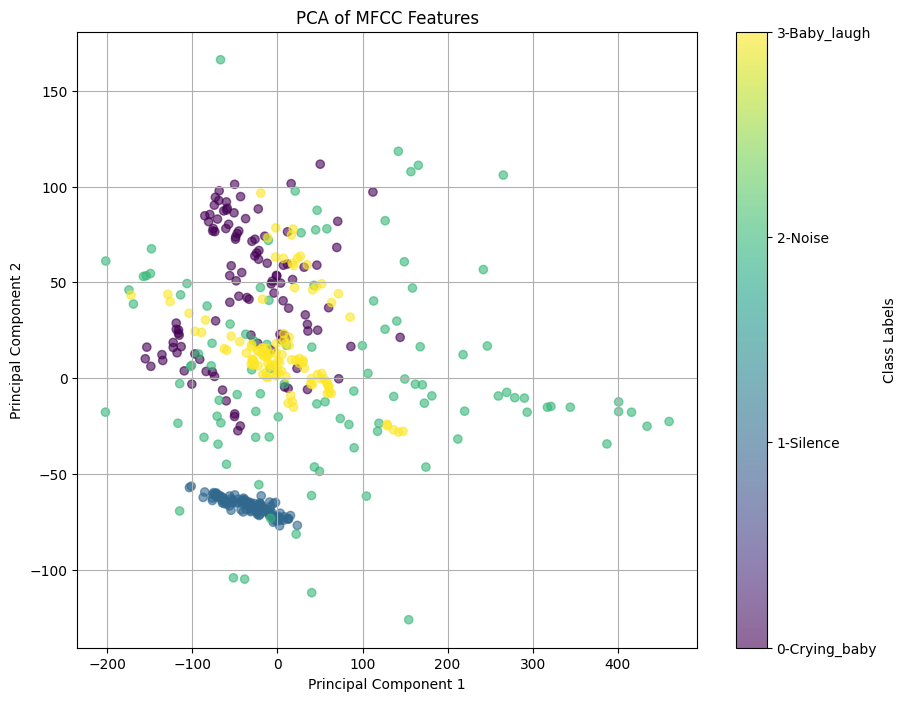

In [22]:
# Plot MFCC features with PCA
display_PCA(features_mfcc, 'PCA of MFCC Features')

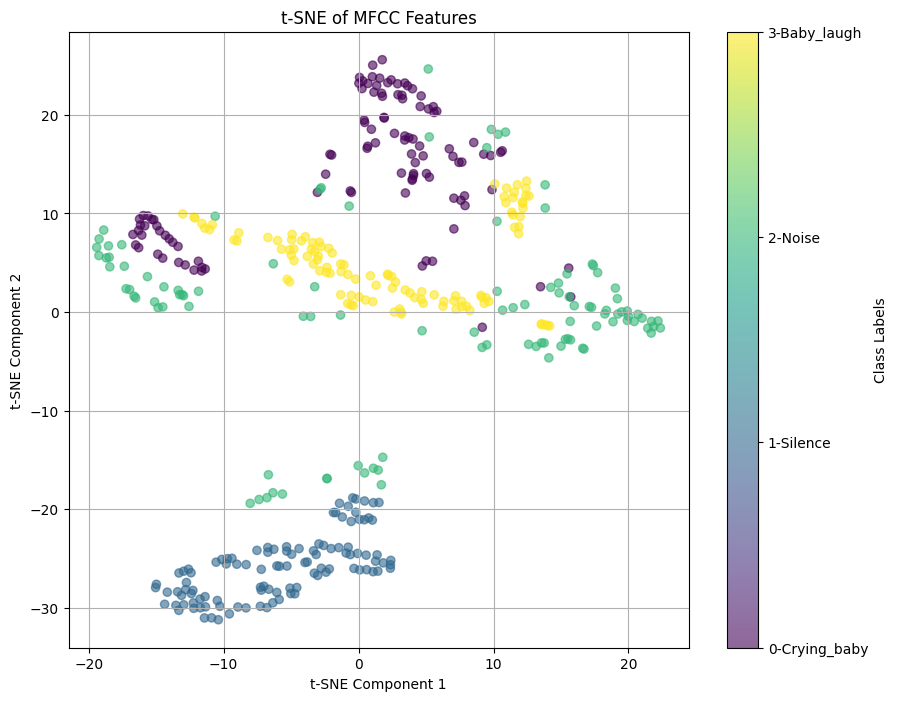

In [23]:
# Plot MFCC features with t-SNE
display_tSNE(features_mfcc, 't-SNE of MFCC Features')

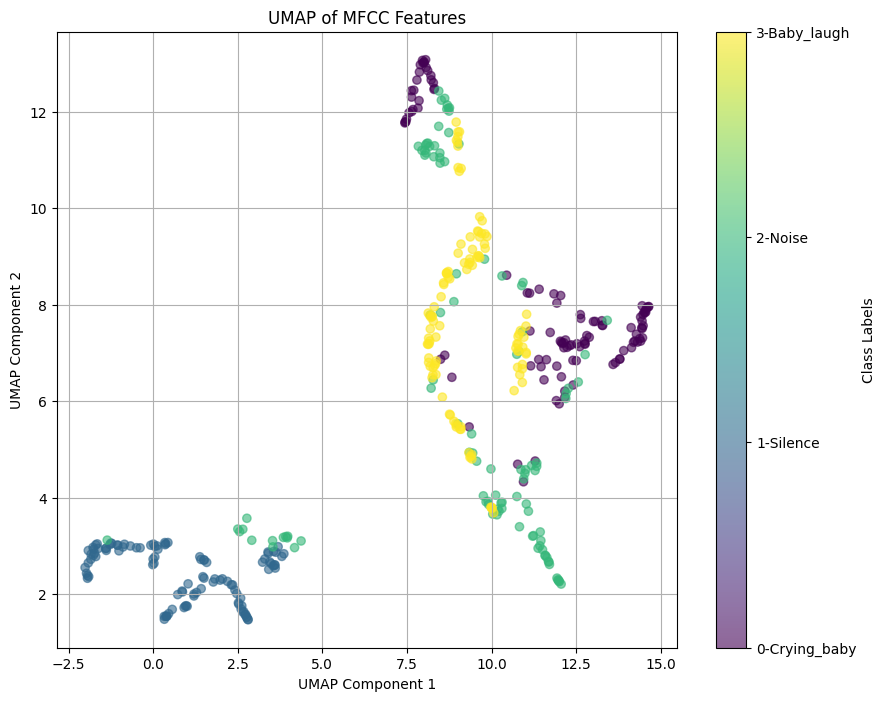

In [24]:
# Plot MFCC features with UMAP
display_UMAP(features_mfcc, 'UMAP of MFCC Features')

## 4. Extract LPC features

In [ ]:
def extract_lpc_features(file_name, n_lpc=10):
    '''
    This function extracts the LPC features from an audio.

    Input:
      - file_name: (str) Name of the audio file.
      - n_lpc: (int) Number of LPC coefficients to extract (default: 10).

    Output:
      - mfcc_list (list): List of LPC features per second.
    '''
    try:
        # Load the audio file and its sample rate
        audio, sample_rate = librosa.load(file_name, sr=None)

        # Applying high-frequency emphasis to audio file
        emphasis_filter = np.array([1, -0.97])
        audio = scipy.signal.lfilter(emphasis_filter, 1, audio)

        # Split audio into frames
        frame_length = int(0.025 * sample_rate)
        frame_step = int(0.01 * sample_rate)
        frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=frame_step).copy()

        # Apply Hamming window
        window = scipy.signal.get_window('hamming', frame_length)
        frames *= window[:, np.newaxis]

        # Calculate the LPC coefficients for each frame
        lpc_coeffs = []

        for frame in frames.T:
            if np.all(frame == 0):
                lpc_coeffs.append(np.zeros(n_lpc))
                continue

            ## Calculate the autocorrelation
            autocorr = np.correlate(frame, frame, mode='full')
            autocorr = autocorr[len(autocorr)//2:]
            R = autocorr[:n_lpc+1]

            # Solving the Toeplitz equation for the LPC coefficients
            try:
                R_matrix = toeplitz(R[:-1])
                R_vector = -R[1:]
                lpc_coef = np.linalg.solve(R_matrix, R_vector)

            except LinAlgError:
                lpc_coef = np.zeros(n_lpc)


            lpc_coeffs.append(lpc_coef)

        # Average of the LPC coefficients over all the frames
        lpc_average = np.mean(lpc_coeffs, axis=0)

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None

    return lpc_average

In [ ]:
# lists for storing LPC features
features_lpc = []

# Iteration on the dictionary that containing the labels
for label, class_label in class_labels.items():

    # Path to the directory where the audio files belonging to the current class are stored
    dir_path = os.path.join('drive/MyDrive/TFM/Classified_audios/', label)

    # Iterate over the files in the directory
    for file_name in os.listdir(dir_path):

        # Generates the full path to each audio file
        file_path = os.path.join(dir_path, file_name)

        # Verification and storage of features
        data = extract_lpc_features(file_path)
        if data is not None:
            features_lpc.append(data)


# Convert to NumPy arrays for training
features_lpc = np.array(features_lpc)

In [4]:
print("Length of LPC features:", len(features_mfcc))

Length of LPC features: 432


In [7]:
np.save('features_lpc.npy', features_lpc)

## 5. Plot LPC features

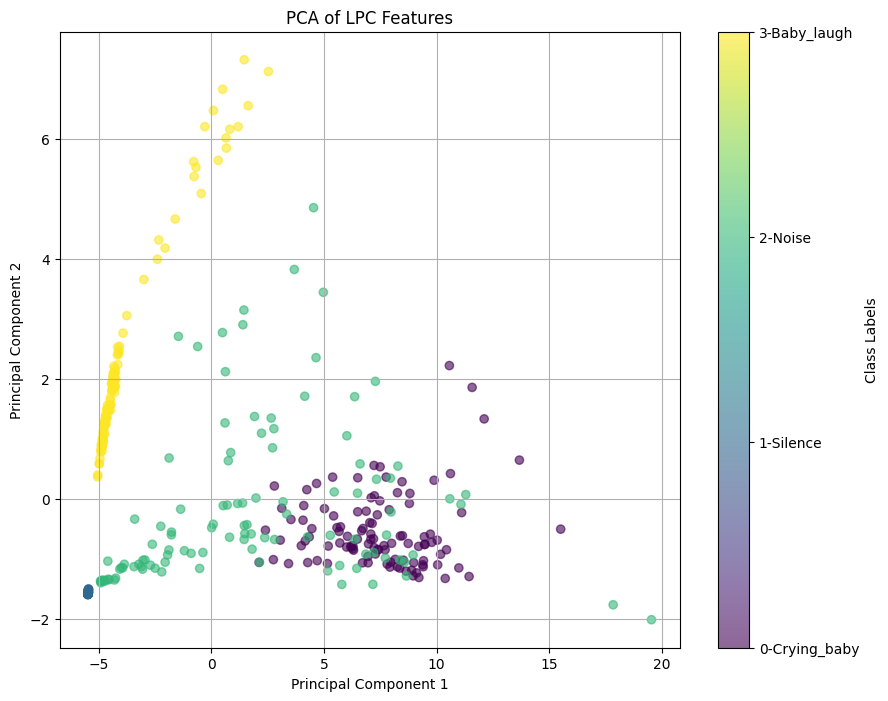

In [25]:
# Plot LPC features with PCA
display_PCA(features_lpc, 'PCA of LPC Features')

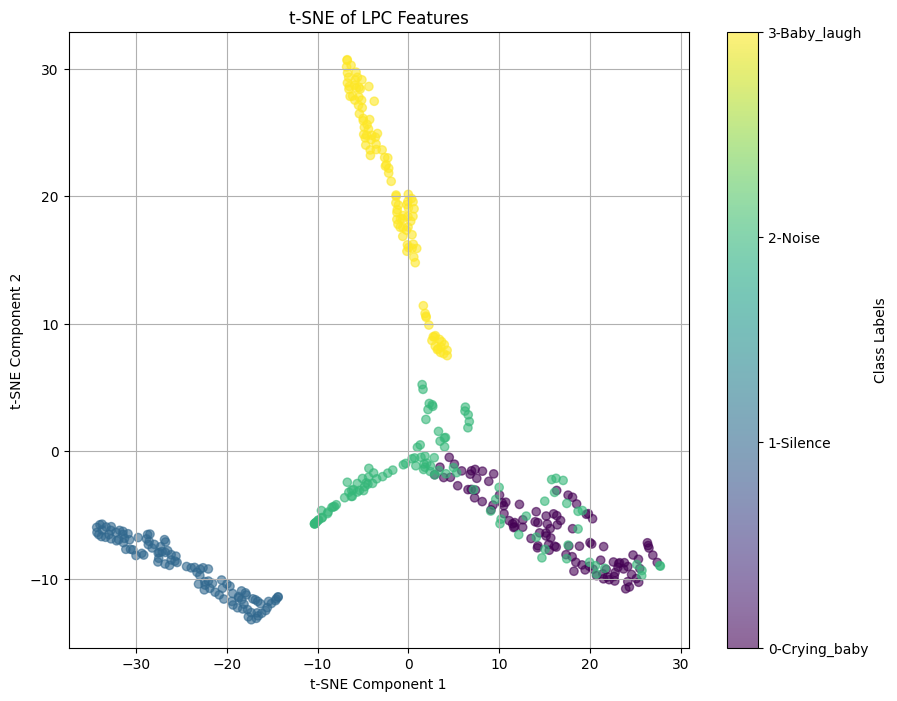

In [13]:
# Plot LPC features with t-SNE
display_tSNE(features_lpc, 't-SNE of LPC Features')

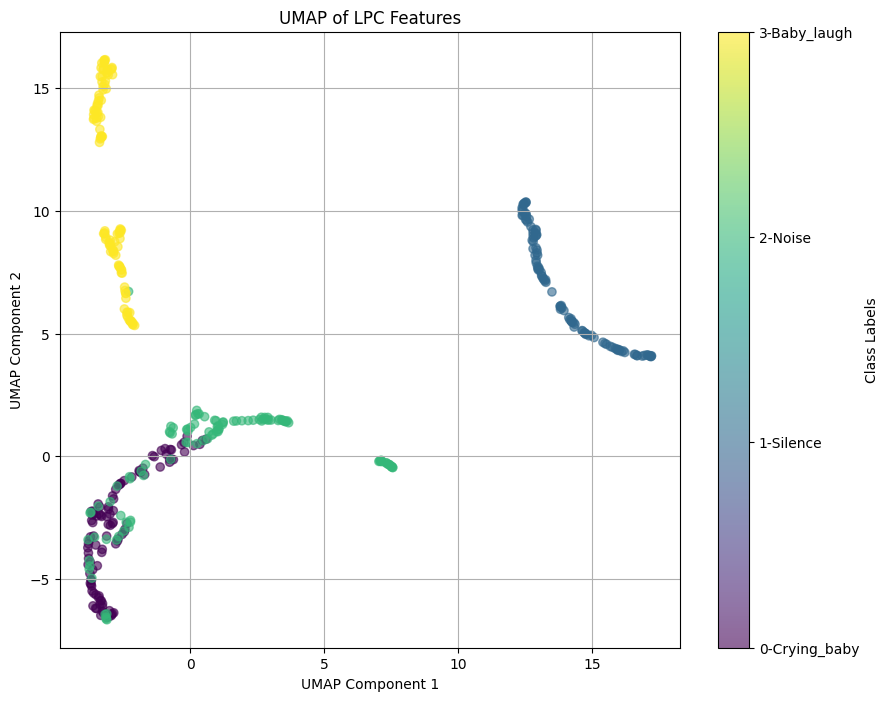

In [14]:
# Plot LPC features with UMAP
display_UMAP(features_lpc, 'UMAP of LPC Features')